In [1]:
import numpy as np
import matplotlib.pyplot as plt # data visualization library
import sklearn
from sklearn.datasets import fetch_olivetti_faces

If possible, update your sklearn version to 1.3.2 to reduce variance in the versions.

# k-means initialization

In [2]:
!pip3 show numpy

Name: numpy
Version: 1.26.3
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2023, NumPy Developers.
        All rights reserved.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are
        met:
        
            * Redistributions of source code must retain the above copyright
               notice, this list of conditions and the following disclaimer.
        
            * Redistributions in binary form must reproduce the above
               copyright notice, this list of conditions and the following
               disclaimer in the documentation and/or other materials provided
               with the distribution.
        
            * Neither the name of the NumPy Developers nor the names of any
               contributors may be used to endorse or promo

If your versions don't match, the following commands (or their anaconda version) could help to get the newest stable release. If you need help with this, please ask the TAs during instruction hours.

In [3]:
!pip3 install numpy --upgrade

In [4]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


The functions generating the datasets are given here:

In [5]:
import sklearn
def generateMoons(epsilon, n):
    moons, labels = sklearn.datasets.make_moons(n_samples=n, noise=epsilon, random_state=7)
    return "moons", moons, labels, 2
def generateBlobs(epsilon, n):
    blobs, labels = sklearn.datasets.make_blobs(n_samples=n,centers=3, cluster_std=[epsilon + 1, epsilon + 1.5, epsilon + 0.5], random_state=54)
    return "blobs", blobs, labels, 3

Implement the centroid initialization here. Right now, it returns a random initialization. 

In [6]:
def init_centroids_greedy_pp(D,r,l=10):
    '''
        :param r: (int) number of centroids (clusters)
        :param D: (np-array) the data matrix
        :param l: (int) number of centroid candidates in each step
        :return: (np-array) 'X' the selected centroids from the dataset
    '''   
    rng =  np.random.default_rng(seed=7) # use this random generator to sample the candidates (sampling according to given probabilities can be done via rng.choice(..))  
    n,d = D.shape #shape of the dataset

    #randomely sample ten centroids and take the one with lowest distance to all the points
    indexes = rng.integers(low=0, high=n, size=l)
    dictionary1 = {}
    for ii in indexes:
        summation = 0
        for j in range(0, n):
            summation += (((D[ii, 0]-D[j, 0])**2)+((D[ii, 1]-D[j, 1])**2))**0.5
        dictionary1[ii] = summation
    i = min(dictionary1)
    X = (D[i]).reshape(-1, 1)

    #give X is a specified number of centroids
    s = 2
    while s <= r:

        #Randomly sample centroids with probabilities based on the centroids distance to X divided by the data points distance to X
        P = []
        sumdistance2 = 0
        for j in range(0, n):
            sumdistance2 += np.linalg.norm(D[j].T - X)
        for ii in range(0,n):        
            probability = np.linalg.norm(D[ii].T - X)/sumdistance2
            P.append(probability) 
        allindices = list(range(0, n))
        sample = rng.choice(allindices, l, p=P)

        #Add the centroid to X with the lowest distance to the data points
        dictionary2 = {}
        for ii in sample:
            summation = 0
            XDII = np.hstack([X, D[ii].reshape(-1,1)])
            for j in allindices:
                summation += np.linalg.norm((D[j].reshape(-1, 1)) - XDII)
            dictionary2[ii] = summation
        iadd = min(dictionary2)
        X = np.hstack([X, D[ii].reshape(-1,1)])
        s = 1+s
    return X

In [7]:
import scipy
def spectral_clustering(W,r, X_init):
    '''
        :param W: (np-array) nxn similarity/weighted adjacency matrix
        :param r: (int) number of centroids (clusters)
        :param X_init: (function) the centroid initialization function 
        :return: (np-array) 'Y' the computed cluster assignment matrix
    '''  

    np.random.seed(0)
    L = np.diag(np.array(W.sum(0))[0]) - W
    v0 = np.random.rand(min(L.shape))
    Lambda, V = scipy.sparse.linalg.eigsh(L, k=r+1, which="SM", v0=v0)
    A = V[:,1:] #remove the first eigenvector, assuming that the graph is conected
    initial_points = X_init(A,r)
    X, Y = kmeans(A, r, initial_points)

    return Y

This is the $k$-means implementation from the lecture accompanying notebook.

In [8]:
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)

def getY(labels):
    '''
        Compute the cluster assignment matrix Y from the categorically encoded labels
    '''
    Y = np.eye(max(labels)+1)[labels]
    return Y

def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes

def update_assignment(D,X):
    dist = np.sum((np.expand_dims(D,2) - X)**2,1)
    labels = np.argmin(dist,1)
    return getY(labels)

def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y

## Running k-means on the blobs dataset
We generate the blobs dataset. Run kmeans based on the initialization technique. Finally, we plot the clustering. The initial centroids are marked in red, and the final centroids are marked in blue. You can use this visualization to see if your initialization makes sense. It doesn't work for spectral clustering.

In [9]:
n=500
dataID, D, labels, r = generateBlobs(0.05,n)
X_init = init_centroids_greedy_pp(D,r)


In [10]:
from sklearn.metrics.cluster import normalized_mutual_info_score

#For calculating NMI score and normalizing the number of data points
X, Y = kmeans(D,r, X_init)
n,d = D.shape
innerproduct = Y@(X.T)
meanerror = (np.linalg.norm(D-Y@(X.T))**2/(n*d))
print(f"the meanerror of the classificiation is {meanerror}")

'''calculating the NMI score'''
#First create a list with all the labels
listprelabels = np.argmax(Y, axis=1)
nmi1 = sklearn.metrics.normalized_mutual_info_score(labels, listprelabels, average_method='arithmetic')
print(f"the nmi of the classification is {nmi1}")

6 iterations
the meanerror of the classificiation is 1.2345652376488239
the nmi of the classification is 0.9527380045058217


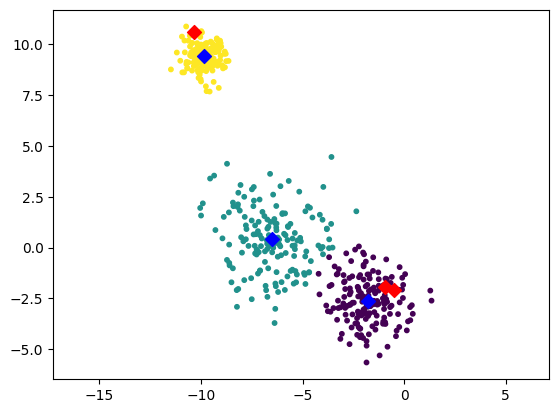

In [11]:
#plot the clusters, initial centroids and their classifications
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
ax.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D') # initial centroids are in red
ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D') # computed centroids are in blue
plt.show()

## Running spectral clustering on the two moons dataset
We generate the moons dataset and compute spectral clustering with the implemented initialization technique.

In [12]:
dataID, D, labels, r = generateMoons(0.05,n)


20 iterations
for KNN: 5 the nmi is 0.001814137505514453


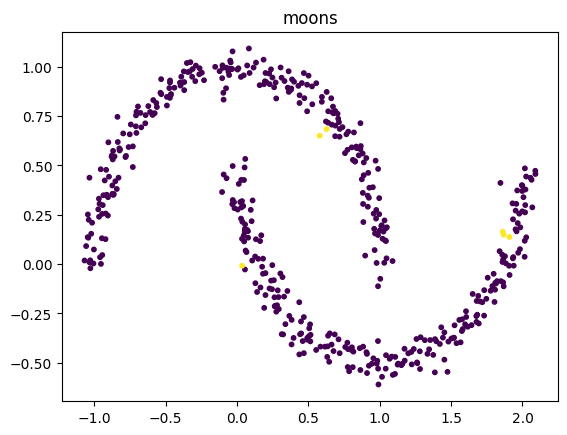

10 iterations
for KNN: 10 the nmi is 0.007008915325063113


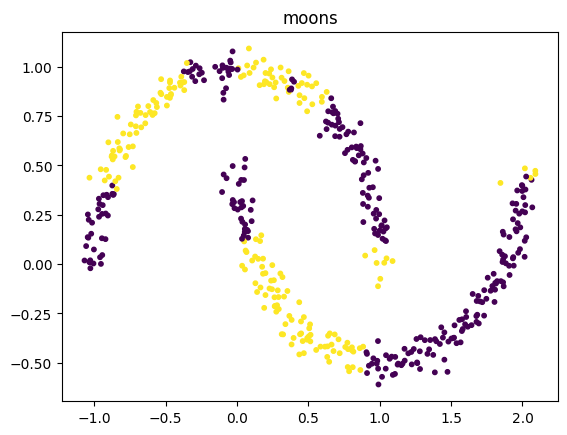

16 iterations
for KNN: 20 the nmi is 0.057432232264657886


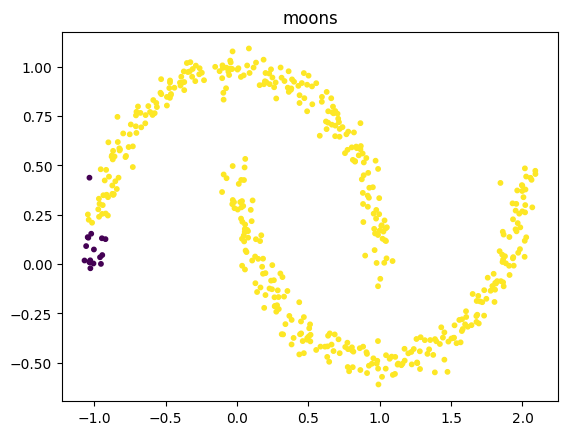

6 iterations
for KNN: 40 the nmi is 0.34371101848544966


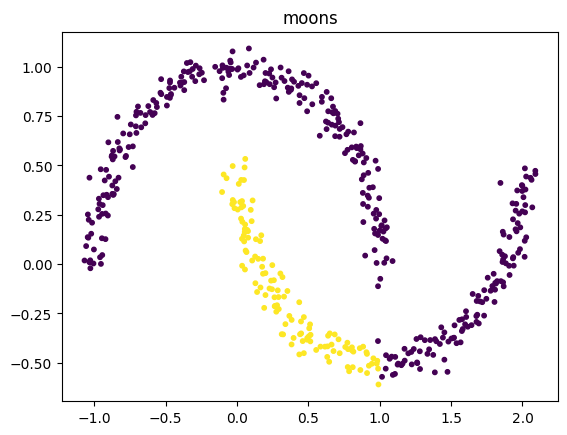

In [20]:

from sklearn.neighbors import radius_neighbors_graph, kneighbors_graph

# Defining the number of KNN we want to have
K = [5, 10, 20, 40]

# for all numbers of KNN we generate the plot and the nmi score
for i in K:
    W = kneighbors_graph(D, n_neighbors=i, mode='connectivity', include_self=False)
    Y2 = spectral_clustering(W,r,init_centroids_greedy_pp)
    labels_pred = np.argmax(Y2, axis=1)
    nmi = sklearn.metrics.normalized_mutual_info_score(labels, labels_pred, average_method='arithmetic')
    print(f"for KNN: {i} the nmi is {nmi}")
    plt.scatter(D[:, 0], D[:, 1], c=np.argmax(Y2,axis=1), s=10)
    plt.title('%s'  % ( dataID) )
    plt.show()

# MNIST ANN

In [14]:
import torch
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
device

'cpu'

## Define the network architecture

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# The embedding architecture returns the 
# output of the penultimate layer
class Embed(nn.Module):
    def __init__(self,embedding_dim=84):
        super(Embed, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(256, 120)
        self.fc2   = nn.Linear(120, embedding_dim)

    def forward(self, x):
        out1 = F.relu(self.conv1(x))
#        print(out1.size())
        out2 = F.max_pool2d(out1, 2)
#        print(out2.size())
        out3 = F.relu(self.conv2(out2))
#        print(out3.size())
        out4 = F.max_pool2d(out3, 2)
#        print(out4.size())
        out5 = out4.view(out4.size(0), -1)
#        print(out5.size())
        out6 = F.relu(self.fc1(out5))
#        print(out6.size())
        out7 = F.relu(self.fc2(out6))
#        print(out7.size())
        return out7     
    
class Net(nn.Module):
    def __init__(self,embedding_dim, classifier):
        super(Net, self).__init__()
        self.embed = Embed(embedding_dim=embedding_dim)
        self.classifier = classifier

    def forward(self, x):
        out = self.embed(x)
        out = self.classifier(out)
        return out

    def conf(self,x):
        out = self.embed(x)
        return F.softmax(self.classifier(out),dim=1)


## Load the data: the first four MNIST classes

In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

classes = ('0', '1', '2', '3')
c=4

# Data
print('==> Preparing data..')
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=trans)

# Select only some classes 
idx = train_data.targets < c
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
trainloader = DataLoader(train_data, batch_size=128, num_workers=2)


testset = datasets.MNIST(root='./data', train=False, download=True, transform=trans)
# Select only some classes 
idx = testset.targets < c
testset.targets = testset.targets[idx]
testset.data = testset.data[idx]
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

==> Preparing data..


## Implementation of the training and testing

In [17]:
import time
def train_epoch(net, criterion, optimizer, trainloader, verbose=False):
    train_loss, correct, conf = 0, 0, 0
    start_time=time.time()
    net.train() 
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        # Set the gradient to zero
        optimizer.zero_grad()
        # Do the forward pass
        logits = net(inputs)
        loss = criterion(logits, targets)
        if verbose:
            print("loss:",loss.item())
        # Do the backward pass
        loss.backward()
        # Do a gradient descent step
        optimizer.step()
    
        with torch.no_grad(): #Disable gradient tracking and compute some statistics
            train_loss += loss.item()
            y_probs = F.softmax(logits, dim=1)
            confBatch, predicted = y_probs.max(1)
            correct += predicted.eq(targets).sum().item()
            conf+=confBatch.sum().item()
    execution_time = (time.time() - start_time)
    n=len(trainloader.dataset)
    print('Loss: %.3f | Acc: %.3f%% (%d/%d) | Conf %.2f | time (s): %.2f'% (train_loss/len(trainloader), 100.*correct/n, correct, n, 100*conf/n, execution_time))
    return (100.*correct/n, 100*conf/n)
  
def test_acc(net, criterion, data_loader):
    net.eval()
    test_loss, correct, conf, total = 0,0,0,0
    with torch.no_grad(): # disable gradient tracking
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            logits = net(inputs)
            loss = criterion(logits, targets)

            test_loss += loss.item()
            y_probs = F.softmax(logits, dim=1)
            confBatch, predicted = y_probs.max(1)
            correct += predicted.eq(targets).sum().item()
            conf+=confBatch.sum().item()
    n=len(data_loader.dataset)
    print('Loss: %.3f | Acc: %.3f%% (%d/%d) | Conf %.2f'% (test_loss/max(len(data_loader),1), 100.*correct/n, correct, n, 100*conf/n))
    return (100.*correct/n, 100*conf/n)

## Create the model and perform the optimization for 10 epochs

In [18]:
d=2
# Model
print('==> Building model..')
classifier = nn.Linear(d, c, bias=True)
print(classifier)
net = Net(embedding_dim=d, classifier=classifier)
net = net.to(device)

criterion = nn.CrossEntropyLoss()

sgd = torch.optim.SGD([{'params': net.parameters()},],
                lr=0.005, momentum=0.9, weight_decay=5e-4)

==> Building model..
Linear(in_features=2, out_features=4, bias=True)


In [19]:
import os
for epoch in range(20):
    print('\nEpoch: %d' % epoch)
    train_epoch(net, criterion, sgd, trainloader)
    (acc,conf) = test_acc(net,criterion, testloader)

print('Saving..')
state = {'net': net.state_dict(),'acc': acc}
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
# torch.save(state, './checkpoint/net.t7')


Epoch: 0


Loss: 1.397 | Acc: 26.008% (6438/24754) | Conf 29.63 | time (s): 15.22
Loss: 1.374 | Acc: 27.303% (1135/4157) | Conf 26.36

Epoch: 1


KeyboardInterrupt: 

## Plot the latent space representations

In [22]:
# Load the saved net
classifier = nn.Linear(d, c,bias=True)
net = Net(embedding_dim=d, classifier=classifier)
checkpoint = torch.load("checkpoint/net.t7",map_location='cpu')
net.load_state_dict(checkpoint['net'])
net.eval()

#state the W matrix
learned_W = classifier.weight.data
print("The learned matrix W:")
for row in range(learned_W.shape[0]):
    print([round(float(learned_W[row, 0]), 2), round(float(learned_W[row, 1]), 2)])

The learned matrix W:
[1.2, -1.35]
[-1.46, 1.01]
[0.56, 0.12]
[-0.6, -0.69]


In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def scatter_pictures(inputs, outputs, samples=30):
    zoom = 0.7
        
    for j in range(min(inputs.shape[0],samples)):
        image = inputs[j,:,:,:].squeeze()
        im = OffsetImage(image, cmap="gray",zoom=zoom)
        ab = AnnotationBbox(im, (outputs[j,0], outputs[j,1]), xycoords='data', frameon=False, alpha=0.5)
        ax.add_artist(ab)

In [ ]:
import matplotlib.pyplot as plt
def plot_conf(conf, show_class_assignment=False, x_max=20, y_max=20, x_min=-1, y_min=-1):
    x = np.arange(x_min, x_max, 0.05)
    y = np.arange(y_min, y_max, 0.05)

    xx, yy = np.meshgrid(x, y)
    X = np.array([xx,yy]).reshape(2,x.shape[0]*y.shape[0]).T
    Z = conf(torch.from_numpy(X).float()).t()
    Z = Z.reshape(-1,y.shape[0],x.shape[0]).cpu().detach().numpy()
    if show_class_assignment:
        h = plt.contourf(x,y,Z.argmax(axis=0),cmap='magma')
    else:
        h = plt.contourf(x,y,Z.max(axis=0),cmap='magma')
        plt.clim(0, 1)
        cb = plt.colorbar()
        cb.set_label('Confidence')
    plt.axis('scaled')

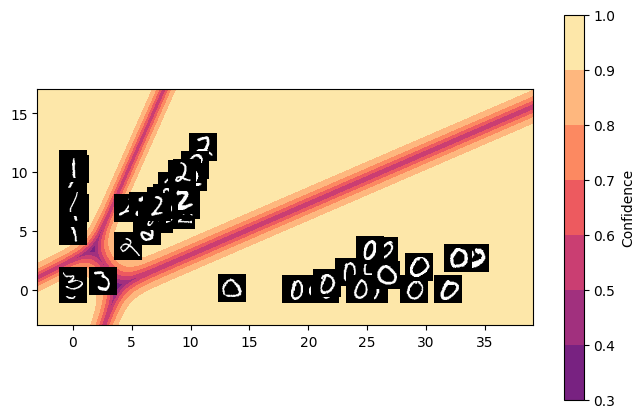

In [ ]:
inputs, targets = next(iter(testloader)) #load a batch
outputs = net.embed(inputs).detach()
fig, ax = plt.subplots(figsize=(8,5))
plot_conf((lambda x: torch.softmax(net.classifier(x),dim=1)), x_max =max(outputs[:,0])+5, y_max =max(outputs[:,1])+5, x_min =min(outputs[:,0])-3, y_min =min(outputs[:,1])-3)
scatter_pictures(inputs, outputs,samples=100)


## Plot Representations of out-of-distribution data

In [ ]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
c=10

# Data
print('==> Preparing data..')
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=trans)
trainloader_fashion = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)


testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=trans)
testloader_fashion = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

==> Preparing data..


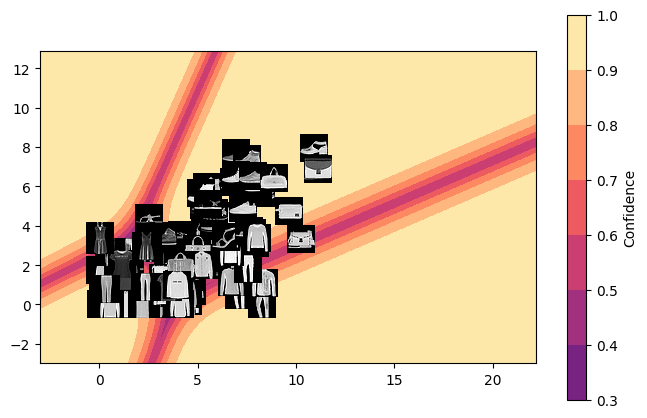

In [ ]:
inputs, targets = next(iter(testloader_fashion))
outputs = net.embed(inputs).detach()
fig, ax = plt.subplots(figsize=(8,5))
plot_conf((lambda x: torch.softmax(net.classifier(x),dim=1)), x_max =max(outputs[:,0])+5, y_max =max(outputs[:,1])+5, x_min =min(outputs[:,0])-3, y_min =min(outputs[:,1])-3)
scatter_pictures(inputs, outputs,samples=100)